<a href="https://colab.research.google.com/github/kdemertzis/LNexamples/blob/main/1_Gaussian_Mixture_Models_EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

sns.set()

# Γκαουσιανά μοντέλα μίξης - Αλγόριθμος EM

## Αλγόριθμος

Τα **γκαουσιανά μοντέλα μίξης** (GMM) προσπαθούν να εντοπίσουν ένα συνδυασμό πολυμετάβλητων γκαουσιανών κατανομών, οι οποίες μπορούν να μοντελοποιούν καλύτερα τα δεδομένα εισόδου. 

Τα βήματα του αλγορίθμου Expectation-Maximization περιγράφονται παρακάτω

1. Αρχικοποίηση των παραμέτρων του μοντέλου

2. Επανάληψη

    2.1. Βήμα Αναμονής: υπολογισμός της πιθανότητας το πρότυπο \\(x_i\\) να προέρχεται από την \\(j\\)-οστή κανονική κατανομή \\(p(j|x_i,\Theta)\\)
    
    2.2. Βήμα Μεγιστοποίησης: Χρησιμοποιώντας τις τιμές των \\(p(j|x_i,\Theta)\\) που υπολογίστηκαν προηγουμένως, εκτίμησε τις νέες τιμές των υπερπαραμέτρων \\(\Theta\\) που μεγιστοποιούν την πιθανοφάνεια
    
3. Επανέλαβε το βήμα 2 μέχρι τη σύγκληση (ή για ένα καθορισμένο αριθμό βημάτων)


## Συνθετικό dataset



In [ ]:
from sklearn.datasets.samples_generator import make_blobs

X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

Στην απλούστερη περίπτωση, τα GMM μπορούν να εντοπίσουν συστάδες που θα εντόπιζαν και διαμεριστικοί αλγόριθμοι, όπως ο $k$-means. Εδώ χρησιμοποιούμε την κλάση [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) του module *mixture* του scikit-learn.

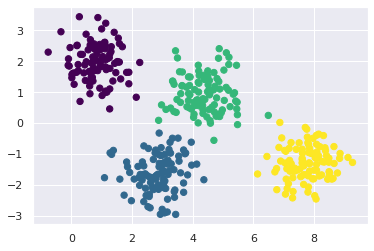

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Ωστόσο, οντας πιθανοτικά μοντέλα, μπορούν να πραγματοποιούν και πιθανοτικές αναθέσεις σε συστάδες, δηλαδή να υπολογίζουν την πιθανότητα ενός οποιουδήποτε σημείου να ανήκει σε συγκεκριμένη συστάδα

In [ ]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.    0.531 0.469]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    1.    0.    0.   ]]


Αυτό μπορούμε να το αποτυπώσουμε οπτικά, μεταβάλλοντας το μέγεθος κάθε προτύπου, συναρτήσει της πιθανότητας να ανήκει στη συγκεκριμένη συστάδα. Έτσι είναι σαν να οπτικοποιούμε την αβεβαιότητα

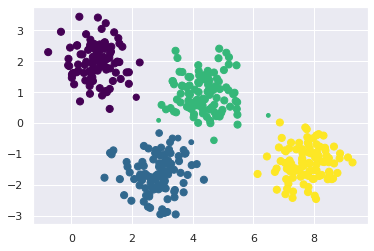

In [ ]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Αυτή η λειτουργία έχει ως αποτέλεσμα η κάθε συστάδα να μην έχει τη μορφή μιας "κλειστής" σφαίρας αλλά ενός πιο ομαλού γκαουσιανού μοντέλου, το οποίο θα απεικονίσουμε με την χρήση των παρακάτω βοηθητικών συναρτήσεων

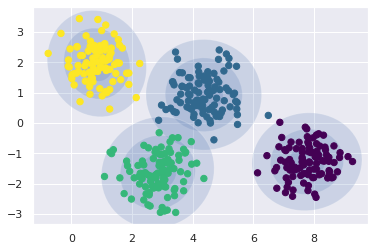

In [ ]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
        
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

Η δύναμη αυτής της προσέγγισης φαίνεται αν "τεντώσουμε" λίγο τα δεδομένα μας.

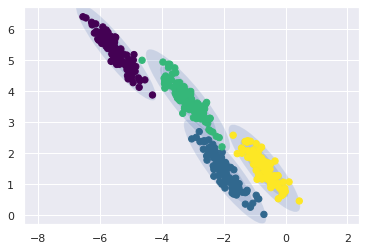

In [ ]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

Γίνεται φανερό ότι τα GMM μπορούν να ανακαλύψουν τη δομή των δεδομένων σε τέτοιες περιπτώσεις, τη στιγμή που άλλες "σφαιρικές" τεχνικές (όπως ο $k$-means) θα αποτύγχαναν. Ειδικότερα, η υλοποίηση των GMMs που παρέχει το scikit-learn μας επιτρέπει μέσω της παραμέτρου *covariance_matrix* να ορίσουμε τη συνδιασπροά και άρα το πιθανό σχήμα κάθε συστάδας. Για παράδειγμα, αν θέσουμε  *covariance_matrix="shperical"*, τότε όλες οι διαστάσεις είναι ίσες ως προς τη συνδιασπορά, με αποτέλεσμα η λειτουργία του GMM να μοιάζει περισσότερο με αυτή του $k$-means. Αν θέσουμε όμως *covariance_matrix="full"*, όπως κάναμε παραπάνω, τότε η κάθε συστάδα μοντελοποιείται ως έλλειψη με τυχαία κατεύθυνση όσον αφορά τον προσανατολισμό. Έτσι όμως η εκπαίδευση γίνεται πιο χρονοβόρα, ειδικά σε χώρους μεγάλων διαστάσεων. Περισσότερα μπορείτε να διαβάσετε στο documentation της κλάσης.

### Χρήση των GMM ως εκτιμητές πυκνότητας

Έστω ότι έχουμε το παρακάτω dataset

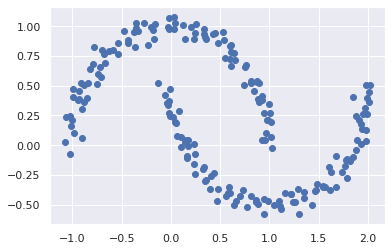

In [ ]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

Ας προσπαθήσουμε να το συσταδοποιήσουμε σε δύο συστάδες με χρήση GMM

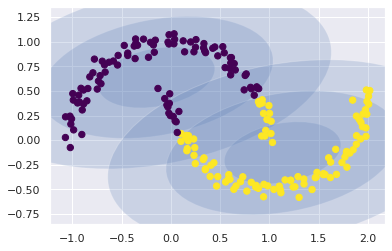

In [ ]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

Παρατηρούμε ότι το αποτέλεσμα δεν είναι διαίτερα χρήσιμο, γιατί τα δύο μοντέλα αλληλοπλέκονται. Ας προσπαθήσουμε να χρησιμοποιήσουμε περισσότερες συστάδες, αγνοώντας τις ετικέτες τους

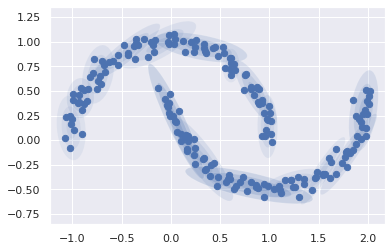

In [ ]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)


Παρατηρούμε ότι σε αυτή την περίπτωση, τα 16 μοντέλα δεν συσταδοποίησαν ορθά τον χώρο των δεδομένων, ωστόσο ανακάλυψαν τη συνολική κατανομή των προτύπων εισόδου. Συνεπώς, μπορούμε να τα χρησιμοποιήσουμε για να δημιουργήσουμε επιπρόσθετα δείγματα, όπως παρακάτω

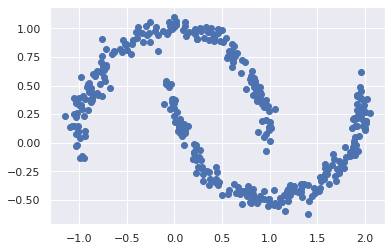

In [ ]:
Xnew = gmm16.sample(400)
plt.scatter(Xnew[0][:, 0], Xnew[0][:, 1]);

Τέλος, με τη χρήση κριτηρίων όπως το [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) ή το [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion) μπορούμε να εκτιμήσουμε το πλήθος των μοντέλων που απαιτούνται για την ορθή λειτουργία του GMM ως εκτιμητή πυκνότητας

Text(0.5, 0, 'n_components')

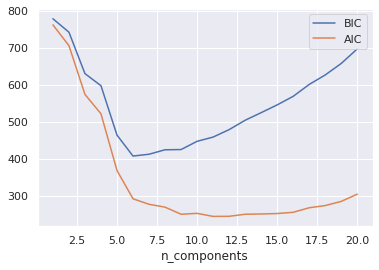

In [ ]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

Ο βέλτιστος αριθμός μοντέλων βρίσκεται στο τοπικό ελάχιστο των δύο δεικτών. Οι συγκεκριμένες γραφικές παραστάσεις δείχνουν ότι η αρχική εκτίμηση που κάναμε (16 μοντέλα) ήταν μάλλον "υπερβολική", μιας και το κριτήριο AIC ορίζει 8-12 μοντέλα και το BIC 5.